CIFAR-10

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

# Import modules

In [1]:
import copy
import gc
import logging
from logging import getLogger
from logging import StreamHandler
from logging import INFO, WARNING
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import warnings
warnings.filterwarnings("ignore")

logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(INFO)
logger.setLevel(INFO)
logger.addHandler(handler)

%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Global vars

In [36]:
TRAIN = "train"
VAL = "val"
TEST = "test"
PHASES = [TRAIN, VAL]

SAVE_PATH = os.path.join(os.getcwd(), "models")

# Utils

In [3]:
def display_formatted_time(elapsed_time, msg=""):
    minutes, seconds = map(int, divmod(elapsed_time, 60))
    print("Elapsed time - {0}: {1}min {2}s".format(msg, minutes, seconds))

In [4]:
def save_model(model_name=""):
    model_path = os.path.join(SAVE_PATH, model_name)
    torch.save(model.state_dict(), model_path)

def load_model(model_name):
    model = Net().to(device)
    model_path = os.path.join(SAVE_PATH, model_name)
    model.load_state_dict(torch.load(model_path))
    return model

# Settings

In [34]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

torch.manual_seed(1)

test_batch_size = 256

# default
params = {
    "batch_size": 512,
    "epochs": 10,
    "lr": 0.001,
    "momentum": 0.9,
}

Device:  cuda


# Load image

In [35]:
def init_datasets(data_transforms):
    """画像前処理変更したら呼ぶ"""
    image_datasets = {phase: torchvision.datasets.CIFAR10(root="../../data",
                                                                                                       train=phase is "train",
                                                                                                       download=True,
                                                                                                       transform=data_transforms[phase])
                                      for phase in PHASES}
    dataset_sizes = {phase: len(image_datasets[phase]) for phase in PHASES}
    return image_datasets, dataset_sizes

def init_dataloaders(batch_size, image_datasets):
    """バッチサイズ変更したら呼ぶ"""
    return {phase: torch.utils.data.DataLoader(image_datasets[phase],
                                                                               batch_size=batch_size,
                                                                               shuffle=True,
                                                                               num_workers=4)
                 for phase in ["train", "val"]}

In [39]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

image_datasets, dataset_sizes = init_datasets(data_transforms)
dataloaders = init_dataloaders(params["batch_size"], image_datasets)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

Files already downloaded and verified
Files already downloaded and verified


 ship   cat plane horse plane truck  frog   dog truck  bird  deer  deer  frog   dog truck horse   dog  deer  ship  deer  frog   cat  deer   dog  bird   cat  deer truck   car   dog   dog   car   dog   cat  deer  ship truck   cat  ship   cat truck  bird   cat   dog horse  ship truck  deer truck  ship plane plane   dog  bird  frog truck  bird truck   dog truck  frog plane  deer   cat  frog truck  frog  ship horse  bird plane  bird  deer horse  ship horse truck   car truck   car truck horse  frog   cat  bird plane truck horse   dog  deer   dog   cat   dog  ship horse   dog truck horse   car plane  bird  ship   dog  ship  frog  bird plane horse plane  deer  deer plane  bird plane  deer  deer horse   car truck plane  bird  bird horse  bird  bird truck   car truck truck plane  deer  ship   dog  frog plane  bird truck   dog   dog   car truck  bird  deer  bird plane  frog horse   cat   car   dog horse truck  deer  frog  ship  frog  bird  ship   cat   car   dog  frog  frog horse   cat horse   do

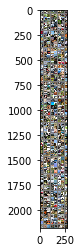

Process Process-818:
Process Process-817:
Traceback (most recent call last):
Process Process-819:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-820:
  File "/home/shitaked/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/shitaked/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shitaked/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shitaked/.local/share/virtualenvs/ml-sandbox-mZj7E2fu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/shitaked/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shitaked/anaconda3/lib/python3.6/multiprocessing/process.py", 

In [42]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(dataloaders[TRAIN])
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(params["batch_size"])))

# Define a Convolution Neural Network

In [19]:
# from net import Net

In [43]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net,  self).__init__()
        self.conv1 = nn.Conv2d(3,  16,  5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2,  2)
        self.conv2 = nn.Conv2d(16,  16,  5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5,  120)
        self.fc2 = nn.Linear(120,  84)
        self.fc3 = nn.Linear(84,  10)

    def forward(self,  x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32x3 ->  28x28x6 ->14x14x6
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  #  ->10x10x16 -> 5x5x16
        x = x.view(-1,  16 * 5 * 5)  # -> 400
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

ResNet

# Train the network

In [44]:
def train(model, criterion, optimizer, scheduler, params):
    since = time.time()
    
    epochs = params["epochs"]

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_loss = dict()
        epoch_acc = dict()
        
        for phase in PHASES:
            if phase == TRAIN:
                is_train = True
                scheduler.step()
                model.train()
            else:
                is_train = False
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 0):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(is_train):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if is_train:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss[phase] = running_loss / dataset_sizes[phase]
            epoch_acc[phase] = running_corrects.double() / dataset_sizes[phase]

            if phase == VAL and epoch_acc[phase] > best_acc:
                best_acc = epoch_acc[phase]
                best_model_weights = copy.deepcopy(model.state_dict())

        print("Epoch {}/{}\tTrain Loss: {:.4f} Acc: {:.4f}\tVal Loss: {:.4f} Acc: {:.4f}".format(
            epoch,
            epochs - 1,
            epoch_loss[TRAIN],
            epoch_acc[TRAIN],
            epoch_loss[VAL],
            epoch_acc[VAL]
        ))

    print()
    print("Best val Acc: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_weights)
    
    print()
    display_formatted_time(time.time() - since)
    return model

In [45]:
def calc_acc():
    """ラベルごとの精度を算出"""
    class_correct = [0. for i in range(len(classes))]
    class_total = [0. for i in range(len(classes))]

    with torch.no_grad():
        for inputs, labels in dataloaders[VAL]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print("Accuracy of\t%5s:\t%2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))

## Train and Eval

In [33]:
params = {
    "batch_size": 512,
    "epochs": 50,
    "lr": 0.001,
    "momentum": 0.9,
}

image_datasets, dataset_sizes = init_datasets(data_transforms=data_transforms)
dataloaders = init_dataloaders(params["batch_size"], image_datasets=image_datasets)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(),
#                                          lr=params["lr"],
#                                          momentum=params["momentum"])
optimizer = optim.Adam(model.parameters(),
                                            lr=params["lr"])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                                              T_max=10,  # Maximum number of iterations
                                                                              eta_min=0,  # 最小学習率
                                                                              last_epoch=-1)  # The index of last epoch

model = train(model, criterion, optimizer, scheduler, params)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/49	Train Loss: 1.6685 Acc: 0.3775	Val Loss: 1.4566 Acc: 0.4660
Epoch 1/49	Train Loss: 1.3080 Acc: 0.5230	Val Loss: 1.2304 Acc: 0.5575
Epoch 2/49	Train Loss: 1.1771 Acc: 0.5756	Val Loss: 1.1965 Acc: 0.5668
Epoch 3/49	Train Loss: 1.0930 Acc: 0.6083	Val Loss: 1.0799 Acc: 0.6154
Epoch 4/49	Train Loss: 1.0445 Acc: 0.6260	Val Loss: 1.0697 Acc: 0.6119
Epoch 5/49	Train Loss: 1.0072 Acc: 0.6403	Val Loss: 1.0287 Acc: 0.6319
Epoch 6/49	Train Loss: 0.9812 Acc: 0.6509	Val Loss: 1.0045 Acc: 0.6429
Epoch 7/49	Train Loss: 0.9601 Acc: 0.6592	Val Loss: 0.9874 Acc: 0.6481
Epoch 8/49	Train Loss: 0.9481 Acc: 0.6644	Val Loss: 0.9764 Acc: 0.6565
Epoch 9/49	Train Loss: 0.9391 Acc: 0.6663	Val Loss: 0.9735 Acc: 0.6577
Epoch 10/49	Train Loss: 0.9383 Acc: 0.6663	Val Loss: 0.9734 Acc: 0.6561
Epoch 11/49	Train Loss: 0.9382 Acc: 0.6660	Val Loss: 0.9715 Acc: 0.6583
Epoch 12/49	Train Loss: 0.9408 Acc: 0.6667	Val Loss: 0.9695 Acc: 0.657

In [46]:
calc_acc()

Accuracy of	plane:	76 %
Accuracy of	  car:	84 %
Accuracy of	 bird:	60 %
Accuracy of	  cat:	51 %
Accuracy of	 deer:	70 %
Accuracy of	  dog:	61 %
Accuracy of	 frog:	82 %
Accuracy of	horse:	77 %
Accuracy of	 ship:	83 %
Accuracy of	truck:	82 %


## Save model

In [47]:
save_model("original_Adam_epoch50")

## Load model

In [182]:
model = load_model("original_SGD_epoch50")

# Learning rate annealing

Cosine Annealing

In [162]:
params = {
    "batch_size": 512,
    "epochs": 100,
    "lr": 0.001,
    "momentum": 0.9,
}

dataloaders = init_dataloaders(batch_size)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                                            lr=params["lr"])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                                              T_max=10,  # Maximum number of iterations
                                                                              eta_min=0,  # 最小学習率
                                                                              last_epoch=-1)  # The index of last epoch

model = train(model, criterion, optimizer, scheduler, params)

Epoch 0/99[624/50000 (20%)]	Train Loss: 1.5328 Acc: 0.4385	Val Loss: 1.2943 Acc: 0.5318
Epoch 1/99[624/50000 (20%)]	Train Loss: 1.2106 Acc: 0.5621	Val Loss: 1.2094 Acc: 0.5717
Epoch 2/99[624/50000 (20%)]	Train Loss: 1.0949 Acc: 0.6089	Val Loss: 1.0720 Acc: 0.6148
Epoch 3/99[624/50000 (20%)]	Train Loss: 1.0265 Acc: 0.6341	Val Loss: 1.0469 Acc: 0.6311
Epoch 4/99[624/50000 (20%)]	Train Loss: 0.9781 Acc: 0.6531	Val Loss: 1.0281 Acc: 0.6424
Epoch 5/99[624/50000 (20%)]	Train Loss: 0.9367 Acc: 0.6682	Val Loss: 0.9452 Acc: 0.6680
Epoch 6/99[624/50000 (20%)]	Train Loss: 0.8969 Acc: 0.6809	Val Loss: 0.9325 Acc: 0.6695
Epoch 7/99[624/50000 (20%)]	Train Loss: 0.8744 Acc: 0.6907	Val Loss: 0.9145 Acc: 0.6821
Epoch 8/99[624/50000 (20%)]	Train Loss: 0.8613 Acc: 0.6944	Val Loss: 0.9054 Acc: 0.6823
Epoch 9/99[624/50000 (20%)]	Train Loss: 0.8455 Acc: 0.7003	Val Loss: 0.8968 Acc: 0.6883
Epoch 10/99[624/50000 (20%)]	Train Loss: 0.8446 Acc: 0.7013	Val Loss: 0.8966 Acc: 0.6886
Epoch 11/99[624/50000 (20%)]	Tr

Epoch 93/99[624/50000 (20%)]	Train Loss: 0.3795 Acc: 0.8705	Val Loss: 0.8431 Acc: 0.7445
Epoch 94/99[624/50000 (20%)]	Train Loss: 0.3938 Acc: 0.8632	Val Loss: 0.8483 Acc: 0.7438
Epoch 95/99[624/50000 (20%)]	Train Loss: 0.4103 Acc: 0.8553	Val Loss: 0.8594 Acc: 0.7377
Epoch 96/99[624/50000 (20%)]	Train Loss: 0.4274 Acc: 0.8497	Val Loss: 0.8952 Acc: 0.7253
Epoch 97/99[624/50000 (20%)]	Train Loss: 0.4433 Acc: 0.8426	Val Loss: 0.8842 Acc: 0.7334
Epoch 98/99[624/50000 (20%)]	Train Loss: 0.4488 Acc: 0.8400	Val Loss: 0.8720 Acc: 0.7323
Epoch 99/99[624/50000 (20%)]	Train Loss: 0.4524 Acc: 0.8388	Val Loss: 0.9268 Acc: 0.7229

Best val Acc: 0.748900

Elapsed time - : 4min 29s


In [ ]:
calc_acc()

StepLR

In [248]:
params = {
    "batch_size": 1024,
    "epochs": 50,
    "lr": 0.001,
    "momentum": 0.9,
}

dataloaders = init_dataloaders(batch_size)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                                            lr=params["lr"])
scheduler = lr_scheduler.StepLR(optimizer=optimizer,
                                                     step_size=10,
                                                     gamma=0.9)

model = train(model, criterion, optimizer, scheduler, params)

Epoch 0/49[624/50000 (20%)]	Train Loss: 1.5811 Acc: 0.4110	Val Loss: 1.3534 Acc: 0.5036
Epoch 1/49[624/50000 (20%)]	Train Loss: 1.2127 Acc: 0.5637	Val Loss: 1.1667 Acc: 0.5807
Epoch 2/49[624/50000 (20%)]	Train Loss: 1.0894 Acc: 0.6124	Val Loss: 1.0854 Acc: 0.6202
Epoch 3/49[624/50000 (20%)]	Train Loss: 1.0249 Acc: 0.6376	Val Loss: 1.0472 Acc: 0.6355
Epoch 4/49[624/50000 (20%)]	Train Loss: 0.9751 Acc: 0.6580	Val Loss: 0.9833 Acc: 0.6490
Epoch 5/49[624/50000 (20%)]	Train Loss: 0.9337 Acc: 0.6704	Val Loss: 0.9825 Acc: 0.6502
Epoch 6/49[624/50000 (20%)]	Train Loss: 0.9030 Acc: 0.6838	Val Loss: 0.9571 Acc: 0.6601
Epoch 7/49[624/50000 (20%)]	Train Loss: 0.8847 Acc: 0.6883	Val Loss: 0.9255 Acc: 0.6736
Epoch 8/49[624/50000 (20%)]	Train Loss: 0.8571 Acc: 0.6982	Val Loss: 0.9048 Acc: 0.6764
Epoch 9/49[624/50000 (20%)]	Train Loss: 0.8268 Acc: 0.7060	Val Loss: 0.9357 Acc: 0.6683
Epoch 10/49[624/50000 (20%)]	Train Loss: 0.8092 Acc: 0.7144	Val Loss: 0.8582 Acc: 0.6950
Epoch 11/49[624/50000 (20%)]	Tr

In [249]:
calc_acc()

Accuracy of	plane:	77 %
Accuracy of	  car:	83 %
Accuracy of	 bird:	58 %
Accuracy of	  cat:	55 %
Accuracy of	 deer:	69 %
Accuracy of	  dog:	65 %
Accuracy of	 frog:	80 %
Accuracy of	horse:	79 %
Accuracy of	 ship:	87 %
Accuracy of	truck:	76 %


# Transfer Learning

## Finetuning ResNet-18

In [49]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

image_datasets, dataset_sizes = init_datasets(data_transforms)
dataloaders = init_dataloaders(params["batch_size"], image_datasets)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
trainset = torchvision.datasets.CIFAR10(root="../../data",
                                                                       train=True,
                                                                       download=True,
                                                                       transform=transforms.Compose([
                                                                           transforms.RandomResizedCrop(224),
                                                                           transforms.RandomHorizontalFlip(),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                       ]))
dataloader[TRAIN] = torch.utils.data.DataLoader(trainset,
                                                                           batch_size=batch_size,
                                                                           shuffle=True,
                                                                           num_workers=2)

testset = torchvision.datasets.CIFAR10(root="../../data",
                                                                      train=False,
                                                                      download=True,
                                                                       transform=transforms.Compose([
                                                                           transforms.Resize(256),
                                                                           transforms.RandomResizedCrop(224),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                       ]))
test_loader = torch.utils.data.DataLoader(testset,
                                                                          batch_size=test_batch_size,
                                                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
params = {
    "batch_size": 16,
    "epochs": 10,
    "lr": 0.001,
    "momentum": 0.9,
}

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

image_datasets, dataset_sizes = init_datasets(data_transforms)
dataloaders = init_dataloaders(params["batch_size"], image_datasets)

# Load pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.conv1 = nn.Conv2d(in_channels=3,
                                                    out_channels=64,
                                                    kernel_size=7,
                                                    stride=2,
                                                    padding=3,
                                                    bias=False)
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(),
                                            lr=params["lr"])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                                              T_max=10,  # Maximum number of iterations
                                                                              eta_min=0,  # 最小学習率
                                                                              last_epoch=-1)  # The index of last epoch

model_ft = train(model_ft, criterion, optimizer, scheduler, params)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/9	Train Loss: 1.7387 Acc: 0.3708	Val Loss: 1.4421 Acc: 0.5036
Epoch 1/9	Train Loss: 1.2732 Acc: 0.5488	Val Loss: 1.1030 Acc: 0.6130
Epoch 2/9	Train Loss: 1.0802 Acc: 0.6244	Val Loss: 0.9498 Acc: 0.6655
Epoch 3/9	Train Loss: 0.9553 Acc: 0.6687	Val Loss: 0.9017 Acc: 0.6852
Epoch 4/9	Train Loss: 0.8681 Acc: 0.6984	Val Loss: 0.8207 Acc: 0.7140
Epoch 5/9	Train Loss: 0.7906 Acc: 0.7255	Val Loss: 0.7459 Acc: 0.7405
Epoch 6/9	Train Loss: 0.7178 Acc: 0.7519	Val Loss: 0.6653 Acc: 0.7708
Epoch 7/9	Train Loss: 0.6653 Acc: 0.7705	Val Loss: 0.6405 Acc: 0.7803
Epoch 8/9	Train Loss: 0.6177 Acc: 0.7858	Val Loss: 0.6066 Acc: 0.7914
Epoch 9/9	Train Loss: 0.5945 Acc: 0.7938	Val Loss: 0.6058 Acc: 0.7930

Best val Acc: 0.793000

Elapsed time - : 26min 57s


In [1]:
since = time.time()

correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

display_formatted_time(time.time() - since)

NameError: name 'time' is not defined

### Fixed feature extractor

In [17]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.conv1 = nn.Conv2d(in_channels=3,
                                                    out_channels=64,
                                                    kernel_size=7,
                                                    stride=2,
                                                    padding=3,
                                                    bias=False)
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)
print(model_ft)

optimizer_ft = optim.SGD(model_ft.parameters(),
                                              lr=lr,
                                              momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
since = time.time()

for epoch in range(epochs):

    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(dataloader[TRAIN], 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        exp_lr_scheduler.step()

        running_loss += loss.item()
        if batch_idx % log_interval == (log_interval - 1):
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRunningLoss: {:.3f}".format(
                epoch, batch_idx * len(inputs), len(dataloader[TRAIN].dataset),
                100. * batch_idx / len(dataloader[TRAIN]), loss.item(), running_loss / log_interval
            ))
            running_loss = 0.0

display_formatted_time(time.time() - since)

In [160]:
since = time.time()

correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

display_formatted_time(time.time() - since)

Accuracy of the network on the 10000 test images: 8 %
Elapsed time - : 0min 26s


## Finetuning VGG

In [37]:
model_ft = models.vgg16(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)
print(model_ft)

optimizer_ft = optim.SGD(model_ft.parameters(),
                                              lr=lr,
                                              momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [38]:
since = time.time()

for epoch in range(epochs):

    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(dataloader[TRAIN], 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        exp_lr_scheduler.step()

        running_loss += loss.item()
        if batch_idx % log_interval == (log_interval - 1):
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRunningLoss: {:.3f}".format(
                epoch, batch_idx * len(inputs), len(dataloader[TRAIN].dataset),
                100. * batch_idx / len(dataloader[TRAIN]), loss.item(), running_loss / log_interval
            ))
            running_loss = 0.0

display_formatted_time(time.time() - since)

Train Epoch: 0 [7996/50000 (16%)]	Loss: 2.159346	RunningLoss: 2.387
Train Epoch: 0 [15996/50000 (32%)]	Loss: 2.379969	RunningLoss: 2.390
Train Epoch: 0 [23996/50000 (48%)]	Loss: 2.332590	RunningLoss: 2.394
Train Epoch: 0 [31996/50000 (64%)]	Loss: 2.595869	RunningLoss: 2.391
Train Epoch: 0 [39996/50000 (80%)]	Loss: 2.534103	RunningLoss: 2.386
Train Epoch: 0 [47996/50000 (96%)]	Loss: 2.623924	RunningLoss: 2.388
Train Epoch: 1 [7996/50000 (16%)]	Loss: 2.777625	RunningLoss: 2.381
Train Epoch: 1 [15996/50000 (32%)]	Loss: 2.251991	RunningLoss: 2.390
Train Epoch: 1 [23996/50000 (48%)]	Loss: 2.551284	RunningLoss: 2.396
Train Epoch: 1 [31996/50000 (64%)]	Loss: 2.533488	RunningLoss: 2.397
Train Epoch: 1 [39996/50000 (80%)]	Loss: 2.538293	RunningLoss: 2.386
Train Epoch: 1 [47996/50000 (96%)]	Loss: 2.136362	RunningLoss: 2.382
Elapsed time - : 11min 39s


In [12]:
since = time.time()

correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

display_formatted_time(time.time() - since)

NameError: name 'model_ft' is not defined

In [41]:
print(labels)
print(outputs)

tensor([8, 7, 1, 9], device='cuda:0')
tensor([[-0.0806, -0.0588, -0.0060, -0.0684,  0.5789, -0.2355,  0.0837,  0.1491,
          0.3314,  0.1944],
        [ 0.1758, -0.4445,  0.3566,  0.0683,  0.2534,  0.4132, -0.0509,  0.3535,
          0.0414, -0.1509],
        [-0.3567, -0.2181, -0.7075,  0.2487, -0.4086, -0.2820,  0.2147, -0.0063,
          0.1472,  0.0601],
        [ 0.3038, -0.3477, -0.2707,  0.1142,  0.3598,  0.2226, -0.0590,  0.2238,
          0.0006, -0.0278]], device='cuda:0', grad_fn=<ThAddmmBackward>)
